<a href="https://colab.research.google.com/github/sankalpachowdhury/Galaxy-Classification-using-CNN/blob/master/Copy_of_Model2_Galaxy_classification_Early_St_%26_MCh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras 
from keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import os, random, shutil

from keras_preprocessing import image


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!unzip "/content/drive/My Drive/Colab Notebooks/Astronomical/Galaxy_classification_project/images_training_rev1.zip"

Streaming output truncated to the last 5000 lines.
  inflating: images_training_rev1/926426.jpg  
  inflating: images_training_rev1/926435.jpg  
  inflating: images_training_rev1/926446.jpg  
  inflating: images_training_rev1/926448.jpg  
  inflating: images_training_rev1/926453.jpg  
  inflating: images_training_rev1/926462.jpg  
  inflating: images_training_rev1/926478.jpg  
  inflating: images_training_rev1/926480.jpg  
  inflating: images_training_rev1/926484.jpg  
  inflating: images_training_rev1/926488.jpg  
  inflating: images_training_rev1/926509.jpg  
  inflating: images_training_rev1/926522.jpg  
  inflating: images_training_rev1/926544.jpg  
  inflating: images_training_rev1/926547.jpg  
  inflating: images_training_rev1/926548.jpg  
  inflating: images_training_rev1/926551.jpg  
  inflating: images_training_rev1/926602.jpg  
  inflating: images_training_rev1/926630.jpg  
  inflating: images_training_rev1/926649.jpg  
  inflating: images_training_rev1/926655.jpg  
  inflati

In [6]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Astronomical/Galaxy_classification_project/training_solutions_rev1.csv')

print(df.head)

<bound method NDFrame.head of        GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0        100008  0.383147  0.616853  ...   0.000000        0.0   0.325512
1        100023  0.327001  0.663777  ...   0.000000        0.0   0.000000
2        100053  0.765717  0.177352  ...   0.000000        0.0   0.000000
3        100078  0.693377  0.238564  ...   0.000000        0.0   0.000000
4        100090  0.933839  0.000000  ...   0.000000        0.0   0.000000
...         ...       ...       ...  ...        ...        ...        ...
61573    999948  0.510379  0.489621  ...   0.000000        0.0   0.226257
61574    999950  0.901216  0.098784  ...   0.000000        0.0   0.000000
61575    999958  0.202841  0.777376  ...   0.000000        0.0   0.072296
61576    999964  0.091000  0.909000  ...   0.023065        0.0   0.045334
61577    999967  0.767000  0.140000  ...   0.000000        0.0   0.023380

[61578 rows x 38 columns]>


In [7]:
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new

In [8]:
df.shape

(61578, 38)

In [9]:
df.head(5)

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,Q5.1,Q5.2,Q5.3,Q5.4,Q6.1,Q6.2,Q7.1,Q7.2,Q7.3,Q8.1,Q8.2,Q8.3,Q8.4,Q8.5,Q8.6,Q8.7,Q9.1,Q9.2,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [10]:
ellipticals = df[(df['Q1.1']>0.8) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()

In [11]:
lenticulars = df[(df['Q1.1']>0.8) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()

In [12]:
spirals = df[(df['Q1.2']>0.8) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()

In [13]:
print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  4555
Total number of lenticular examples:  3861
Total number of spiral examples:  3078


In [14]:
source_path = '/content/images_training_rev1'
dest_path = '/content/data'

In [15]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')


In [16]:
_proc_images(source_path, dest_path, 'elliptical', ellipticals, 0.9)
_proc_images(source_path, dest_path, 'lenticular', lenticulars, 0.9)
_proc_images(source_path, dest_path, 'spiral', spirals, 0.9)

elliptical done!
lenticular done!
spiral done!


Data Processing

In [17]:
import os
import PIL
import PIL.Image

In [18]:
!pip install Augmentor

In [19]:
import Augmentor

p1 = Augmentor.Pipeline(source_directory='/content/data/train/elliptical',output_directory = '/content/Data1/Train/elliptical')
p2 = Augmentor.Pipeline(source_directory='/content/data/train/lenticular',output_directory = '/content/Data1/Train/lenticular')
p3 = Augmentor.Pipeline(source_directory='/content/data/train/spiral',output_directory = '/content/Data1/Train/spiral')

#Defining our method of Image Augmentation
p1.rotate90(probability=0.5)
p1.rotate270(probability=0.5)
p1.flip_left_right(probability=0.8)
p1.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
p1.resize(probability=1.0, width=150, height=150)

p2.rotate90(probability=0.5)
p2.rotate270(probability=0.5)
p2.flip_left_right(probability=0.8)
p2.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
p2.resize(probability=1.0, width=150, height=150)

p3.rotate90(probability=0.5)
p3.rotate270(probability=0.5)
p3.flip_left_right(probability=0.8)
p3.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
p3.resize(probability=1.0, width=150, height=150)

p1.sample(8000)
p2.sample(8000)
p3.sample(8000)

Initialised with 4099 image(s) found.
Output directory set to /content/Data1/Train/elliptical.Initialised with 3474 image(s) found.
Output directory set to /content/Data1/Train/lenticular.

Executing Pipeline:   0%|          | 0/8000 [00:00<?, ? Samples/s]

Initialised with 2770 image(s) found.
Output directory set to /content/Data1/Train/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC87E206D8>: 100%|██████████| 8000/8000 [01:06<00:00, 120.78 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC88025550>: 100%|██████████| 8000/8000 [01:05<00:00, 121.36 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC882789E8>: 100%|██████████| 8000/8000 [01:06<00:00, 120.64 Samples/s]


In [20]:
v1 = Augmentor.Pipeline(source_directory='/content/data/validation/elliptical',output_directory = '/content/Data1/Test/elliptical')
v2 = Augmentor.Pipeline(source_directory='/content/data/validation/lenticular',output_directory = '/content/Data1/Test/lenticular')
v3 = Augmentor.Pipeline(source_directory='/content/data/validation/spiral',output_directory = '/content/Data1/Test/spiral')

#Defining our method of Image Augmentation
v1.rotate90(probability=0.5)
v1.rotate270(probability=0.5)
v1.flip_left_right(probability=0.8)
v1.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
v1.resize(probability=1.0, width=150, height=150)

v2.rotate90(probability=0.5)
v2.rotate270(probability=0.5)
v2.flip_left_right(probability=0.8)
v2.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
v2.resize(probability=1.0, width=150, height=150)

v3.rotate90(probability=0.5)
v3.rotate270(probability=0.5)
v3.flip_left_right(probability=0.8)
v3.flip_top_bottom(probability=0.3)
#p1.crop_random(probability=1, percentage_area=0.5)
v3.resize(probability=1.0, width=150, height=150)

v1.sample(1000)
v2.sample(1000)
v3.sample(1000)

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC883FC668>:   0%|          | 1/1000 [00:00<01:44,  9.60 Samples/s]

Initialised with 456 image(s) found.
Output directory set to /content/Data1/Test/elliptical.Initialised with 387 image(s) found.
Output directory set to /content/Data1/Test/lenticular.Initialised with 308 image(s) found.
Output directory set to /content/Data1/Test/spiral.

Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC8857E0F0>: 100%|██████████| 1000/1000 [00:08<00:00, 117.74 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC88555DA0>: 100%|██████████| 1000/1000 [00:08<00:00, 114.23 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=150x150 at 0x7EFC87A6C400>: 100%|██████████| 1000/1000 [00:08<00:00, 113.76 Samples/s]


In [21]:
train_dir = '/content/Data1/Train'
validation_dir = '/content/Data1/Test'

In [22]:

total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Total train: 24000
Total validation: 3000


In [23]:
target = (150, 150)
batch_size = 32

In [24]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=target,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         class_mode='categorical')

Found 24000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [25]:
r_coeff = 0.001

In [33]:
from keras import regularizers


model = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    # second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    # fourth convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    
    # 512 neuron fully connected hidden layer
    #tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
#model1.add()
#tf.keras.layers.Dropout(0.5),
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)       

In [34]:
from tensorflow.keras.optimizers import Adam 

model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [35]:
EPOCHS = 50

Implementing EarlyStopping and ModelCheckpoint 

**Note 1:**
While implementing EarlyStopping, ModelCheckpoint use
**from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint**
instead of 
**from keras.callbacks import EarlyStopping, ModelCheckpoint**
as it throws 'EarlyStopping' object has no attribute 'on_train_batch_begin'
as Early Stopping and all these callbacks should be referenced from Tensorflow module

**Note 2:**
1. baseline val_loss is taken as 0.20, after that earlystopping will be executed  to stop the training
2. The best model will be stored inside **best_model.h5** file

In [ ]:
from keras.callbacks import TensorBoard

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from time import time

# Create a TensorBoard instance with the path to the logs directory
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

# Early Stopping object
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose=1, patience = 50, baseline = 0.2791)

# ModelCheckpoint object
mc = ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 0)

history = model.fit_generator(train_generator,
                    epochs=EPOCHS,
                    validation_data = validation_generator,
                    callbacks=[es, mc],
                    verbose=1)

Evaluating the model

**Note:** Here also use
from tensorflow.keras.models import load_model
instead of 
from tensorflow.keras.models import load_model

In [31]:
from tensorflow.keras.models import load_model

saved_model = load_model('best_model.h5')
_, train_acc = saved_model.evaluate(train_generator)
_, validation_acc = saved_model.evaluate(validation_generator)
print('Training accuracy: {0}\nValidation accuracy: {1}'.format(train_acc, validation_acc))

 80/750 [==>...........................] - ETA: 2:05 - loss: 0.6227 - acc: 0.7391

KeyboardInterrupt: ignored

Visualizing the performance of the training

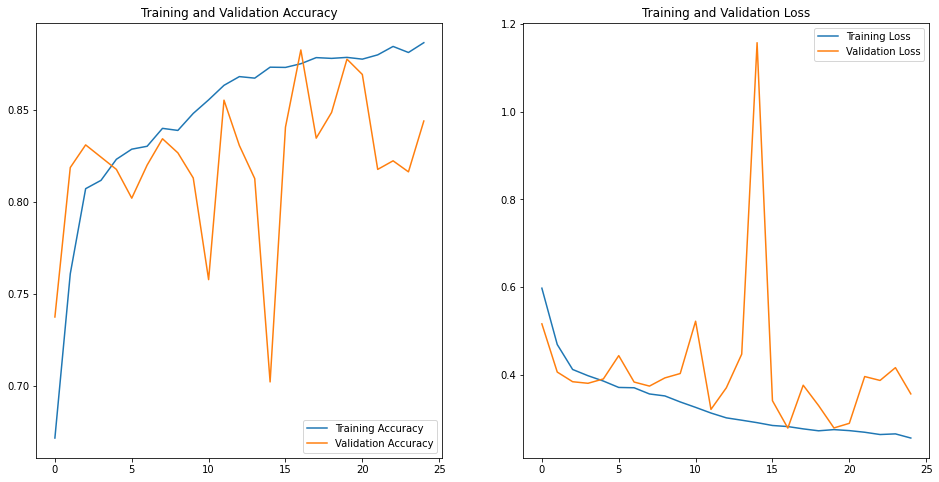

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [ ]:
# launch TensorBoard (data won't show up until after the first epoch)
tensorboard("logs/run_a")

TypeError: ignored

In [ ]:
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_lossesd = PlotLosses()

In [ ]:
model.evaluate(train_generator)

NameError: ignored